### Importing libraries

In [1]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import KFold

# machine learning
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

### 1. Load the dataset

In [2]:
# Load files into a pandas dataframe
DATA_PATH = 'https://raw.githubusercontent.com/ayamlearning/Financial_Inclusion_Africa/main/data'
df = pd.read_csv(os.path.join(DATA_PATH, 'Train.csv'))
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [3]:
# Let’s observe the shape of our datasets.
print('data shape :', df.shape)

data shape : (23524, 13)


In [4]:
# inspect train data
df.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [5]:
# Check for missing values
print('missing values:', df.isnull().sum())

missing values: country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64


We don't have missing data in our dataset.



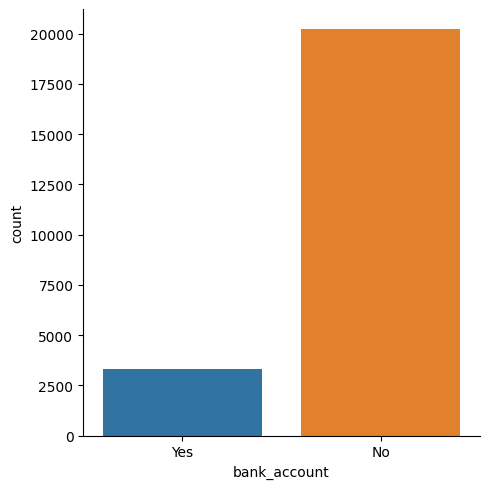

In [6]:
# Explore Target distribution
sns.catplot(x="bank_account", kind="count", data=df)

### 2. Understand the dataset
We can get more information about the features presented by using the info() method from pandas.


In [7]:
 #show some information about the dataset
 print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB
None


In [8]:
categorical = list(df.select_dtypes(include=['object']).columns)
categorical.remove("uniqueid")
categorical.remove("bank_account")
numerical = list(df.select_dtypes(include=['int64']).columns)
target = ['bank_account']

In [9]:
from IPython.display import display

In [10]:
df['bank_account']=df['bank_account'].replace({'Yes': 1,
                                               'No': 0})

In [11]:
global_bank_acc = df.bank_account.mean()

In [12]:
for c in categorical:
  for c in categorical:
    print(c)
    df_group = df.groupby(c).bank_account.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_bank_acc
    df_group['risk'] = df_group['mean'] / global_bank_acc
    display(df_group)
    print()
    print()

country


,mean,count,diff,risk
country,,,,
Kenya,0.250659,6068,0.109867,1.780346
Rwanda,0.114825,8735,-0.025967,0.815566
Tanzania,0.091692,6620,-0.049101,0.651256
Uganda,0.086149,2101,-0.054643,0.611890




location_type


,mean,count,diff,risk
location_type,,,,
Rural,0.116503,14343,-0.024290,0.82748
Urban,0.178739,9181,0.037946,1.26952




cellphone_access


,mean,count,diff,risk
cellphone_access,,,,
No,0.017133,6070,-0.123659,0.121693
Yes,0.183797,17454,0.043005,1.305450




gender_of_respondent


,mean,count,diff,risk
gender_of_respondent,,,,
Female,0.106795,13877,-0.033997,0.758531
Male,0.189696,9647,0.048904,1.347348




relationship_with_head


,mean,count,diff,risk
relationship_with_head,,,,
Child,0.086586,2229,-0.054206,0.614990
Head of Household,0.177149,12831,0.036357,1.258229
Other non-relatives,0.105263,190,-0.035529,0.747648
Other relative,0.098802,668,-0.041990,0.701760
Parent,0.059853,1086,-0.080940,0.425113
Spouse,0.106595,6520,-0.034197,0.757108




marital_status


,mean,count,diff,risk
marital_status,,,,
Divorced/Seperated,0.112717,2076,-0.028076,0.800589
Dont know,0.250000,8,0.109208,1.775664
Married/Living together,0.173598,10749,0.032805,1.233004
Single/Never Married,0.121007,7983,-0.019785,0.859472
Widowed,0.090103,2708,-0.050689,0.639974




education_level


,mean,count,diff,risk
education_level,,,,
No formal education,0.038981,4515,-0.101811,0.276870
Other/Dont know/RTA,0.314286,35,0.173493,2.232264
Primary education,0.085451,12791,-0.055342,0.606927
Secondary education,0.232773,4223,0.091981,1.653306
Tertiary education,0.510804,1157,0.370011,3.628064
Vocational/Specialised training,0.570361,803,0.429569,4.051080




job_type


,mean,count,diff,risk
job_type,,,,
Dont Know/Refuse to answer,0.111111,126,-0.029681,0.789184
Farming and Fishing,0.116706,5441,-0.024086,0.828926
Formally employed Government,0.775194,387,0.634401,5.505936
Formally employed Private,0.541232,1055,0.400440,3.844187
Government Dependent,0.202429,247,0.061637,1.437785
Informally employed,0.079507,5597,-0.061286,0.564710
No Income,0.020734,627,-0.120059,0.147264
Other Income,0.181481,1080,0.040689,1.289001
Remittance Dependent,0.094974,2527,-0.045818,0.674570




country


,mean,count,diff,risk
country,,,,
Kenya,0.250659,6068,0.109867,1.780346
Rwanda,0.114825,8735,-0.025967,0.815566
Tanzania,0.091692,6620,-0.049101,0.651256
Uganda,0.086149,2101,-0.054643,0.611890




location_type


,mean,count,diff,risk
location_type,,,,
Rural,0.116503,14343,-0.024290,0.82748
Urban,0.178739,9181,0.037946,1.26952




cellphone_access


,mean,count,diff,risk
cellphone_access,,,,
No,0.017133,6070,-0.123659,0.121693
Yes,0.183797,17454,0.043005,1.305450




gender_of_respondent


,mean,count,diff,risk
gender_of_respondent,,,,
Female,0.106795,13877,-0.033997,0.758531
Male,0.189696,9647,0.048904,1.347348




relationship_with_head


,mean,count,diff,risk
relationship_with_head,,,,
Child,0.086586,2229,-0.054206,0.614990
Head of Household,0.177149,12831,0.036357,1.258229
Other non-relatives,0.105263,190,-0.035529,0.747648
Other relative,0.098802,668,-0.041990,0.701760
Parent,0.059853,1086,-0.080940,0.425113
Spouse,0.106595,6520,-0.034197,0.757108




marital_status


,mean,count,diff,risk
marital_status,,,,
Divorced/Seperated,0.112717,2076,-0.028076,0.800589
Dont know,0.250000,8,0.109208,1.775664
Married/Living together,0.173598,10749,0.032805,1.233004
Single/Never Married,0.121007,7983,-0.019785,0.859472
Widowed,0.090103,2708,-0.050689,0.639974




education_level


,mean,count,diff,risk
education_level,,,,
No formal education,0.038981,4515,-0.101811,0.276870
Other/Dont know/RTA,0.314286,35,0.173493,2.232264
Primary education,0.085451,12791,-0.055342,0.606927
Secondary education,0.232773,4223,0.091981,1.653306
Tertiary education,0.510804,1157,0.370011,3.628064
Vocational/Specialised training,0.570361,803,0.429569,4.051080




job_type


,mean,count,diff,risk
job_type,,,,
Dont Know/Refuse to answer,0.111111,126,-0.029681,0.789184
Farming and Fishing,0.116706,5441,-0.024086,0.828926
Formally employed Government,0.775194,387,0.634401,5.505936
Formally employed Private,0.541232,1055,0.400440,3.844187
Government Dependent,0.202429,247,0.061637,1.437785
Informally employed,0.079507,5597,-0.061286,0.564710
No Income,0.020734,627,-0.120059,0.147264
Other Income,0.181481,1080,0.040689,1.289001
Remittance Dependent,0.094974,2527,-0.045818,0.674570




country


,mean,count,diff,risk
country,,,,
Kenya,0.250659,6068,0.109867,1.780346
Rwanda,0.114825,8735,-0.025967,0.815566
Tanzania,0.091692,6620,-0.049101,0.651256
Uganda,0.086149,2101,-0.054643,0.611890




location_type


,mean,count,diff,risk
location_type,,,,
Rural,0.116503,14343,-0.024290,0.82748
Urban,0.178739,9181,0.037946,1.26952




cellphone_access


,mean,count,diff,risk
cellphone_access,,,,
No,0.017133,6070,-0.123659,0.121693
Yes,0.183797,17454,0.043005,1.305450




gender_of_respondent


,mean,count,diff,risk
gender_of_respondent,,,,
Female,0.106795,13877,-0.033997,0.758531
Male,0.189696,9647,0.048904,1.347348




relationship_with_head


,mean,count,diff,risk
relationship_with_head,,,,
Child,0.086586,2229,-0.054206,0.614990
Head of Household,0.177149,12831,0.036357,1.258229
Other non-relatives,0.105263,190,-0.035529,0.747648
Other relative,0.098802,668,-0.041990,0.701760
Parent,0.059853,1086,-0.080940,0.425113
Spouse,0.106595,6520,-0.034197,0.757108




marital_status


,mean,count,diff,risk
marital_status,,,,
Divorced/Seperated,0.112717,2076,-0.028076,0.800589
Dont know,0.250000,8,0.109208,1.775664
Married/Living together,0.173598,10749,0.032805,1.233004
Single/Never Married,0.121007,7983,-0.019785,0.859472
Widowed,0.090103,2708,-0.050689,0.639974




education_level


,mean,count,diff,risk
education_level,,,,
No formal education,0.038981,4515,-0.101811,0.276870
Other/Dont know/RTA,0.314286,35,0.173493,2.232264
Primary education,0.085451,12791,-0.055342,0.606927
Secondary education,0.232773,4223,0.091981,1.653306
Tertiary education,0.510804,1157,0.370011,3.628064
Vocational/Specialised training,0.570361,803,0.429569,4.051080




job_type


,mean,count,diff,risk
job_type,,,,
Dont Know/Refuse to answer,0.111111,126,-0.029681,0.789184
Farming and Fishing,0.116706,5441,-0.024086,0.828926
Formally employed Government,0.775194,387,0.634401,5.505936
Formally employed Private,0.541232,1055,0.400440,3.844187
Government Dependent,0.202429,247,0.061637,1.437785
Informally employed,0.079507,5597,-0.061286,0.564710
No Income,0.020734,627,-0.120059,0.147264
Other Income,0.181481,1080,0.040689,1.289001
Remittance Dependent,0.094974,2527,-0.045818,0.674570




country


,mean,count,diff,risk
country,,,,
Kenya,0.250659,6068,0.109867,1.780346
Rwanda,0.114825,8735,-0.025967,0.815566
Tanzania,0.091692,6620,-0.049101,0.651256
Uganda,0.086149,2101,-0.054643,0.611890




location_type


,mean,count,diff,risk
location_type,,,,
Rural,0.116503,14343,-0.024290,0.82748
Urban,0.178739,9181,0.037946,1.26952




cellphone_access


,mean,count,diff,risk
cellphone_access,,,,
No,0.017133,6070,-0.123659,0.121693
Yes,0.183797,17454,0.043005,1.305450




gender_of_respondent


,mean,count,diff,risk
gender_of_respondent,,,,
Female,0.106795,13877,-0.033997,0.758531
Male,0.189696,9647,0.048904,1.347348




relationship_with_head


,mean,count,diff,risk
relationship_with_head,,,,
Child,0.086586,2229,-0.054206,0.614990
Head of Household,0.177149,12831,0.036357,1.258229
Other non-relatives,0.105263,190,-0.035529,0.747648
Other relative,0.098802,668,-0.041990,0.701760
Parent,0.059853,1086,-0.080940,0.425113
Spouse,0.106595,6520,-0.034197,0.757108




marital_status


,mean,count,diff,risk
marital_status,,,,
Divorced/Seperated,0.112717,2076,-0.028076,0.800589
Dont know,0.250000,8,0.109208,1.775664
Married/Living together,0.173598,10749,0.032805,1.233004
Single/Never Married,0.121007,7983,-0.019785,0.859472
Widowed,0.090103,2708,-0.050689,0.639974




education_level


,mean,count,diff,risk
education_level,,,,
No formal education,0.038981,4515,-0.101811,0.276870
Other/Dont know/RTA,0.314286,35,0.173493,2.232264
Primary education,0.085451,12791,-0.055342,0.606927
Secondary education,0.232773,4223,0.091981,1.653306
Tertiary education,0.510804,1157,0.370011,3.628064
Vocational/Specialised training,0.570361,803,0.429569,4.051080




job_type


,mean,count,diff,risk
job_type,,,,
Dont Know/Refuse to answer,0.111111,126,-0.029681,0.789184
Farming and Fishing,0.116706,5441,-0.024086,0.828926
Formally employed Government,0.775194,387,0.634401,5.505936
Formally employed Private,0.541232,1055,0.400440,3.844187
Government Dependent,0.202429,247,0.061637,1.437785
Informally employed,0.079507,5597,-0.061286,0.564710
No Income,0.020734,627,-0.120059,0.147264
Other Income,0.181481,1080,0.040689,1.289001
Remittance Dependent,0.094974,2527,-0.045818,0.674570




country


,mean,count,diff,risk
country,,,,
Kenya,0.250659,6068,0.109867,1.780346
Rwanda,0.114825,8735,-0.025967,0.815566
Tanzania,0.091692,6620,-0.049101,0.651256
Uganda,0.086149,2101,-0.054643,0.611890




location_type


,mean,count,diff,risk
location_type,,,,
Rural,0.116503,14343,-0.024290,0.82748
Urban,0.178739,9181,0.037946,1.26952




cellphone_access


,mean,count,diff,risk
cellphone_access,,,,
No,0.017133,6070,-0.123659,0.121693
Yes,0.183797,17454,0.043005,1.305450




gender_of_respondent


,mean,count,diff,risk
gender_of_respondent,,,,
Female,0.106795,13877,-0.033997,0.758531
Male,0.189696,9647,0.048904,1.347348




relationship_with_head


,mean,count,diff,risk
relationship_with_head,,,,
Child,0.086586,2229,-0.054206,0.614990
Head of Household,0.177149,12831,0.036357,1.258229
Other non-relatives,0.105263,190,-0.035529,0.747648
Other relative,0.098802,668,-0.041990,0.701760
Parent,0.059853,1086,-0.080940,0.425113
Spouse,0.106595,6520,-0.034197,0.757108




marital_status


,mean,count,diff,risk
marital_status,,,,
Divorced/Seperated,0.112717,2076,-0.028076,0.800589
Dont know,0.250000,8,0.109208,1.775664
Married/Living together,0.173598,10749,0.032805,1.233004
Single/Never Married,0.121007,7983,-0.019785,0.859472
Widowed,0.090103,2708,-0.050689,0.639974




education_level


,mean,count,diff,risk
education_level,,,,
No formal education,0.038981,4515,-0.101811,0.276870
Other/Dont know/RTA,0.314286,35,0.173493,2.232264
Primary education,0.085451,12791,-0.055342,0.606927
Secondary education,0.232773,4223,0.091981,1.653306
Tertiary education,0.510804,1157,0.370011,3.628064
Vocational/Specialised training,0.570361,803,0.429569,4.051080




job_type


,mean,count,diff,risk
job_type,,,,
Dont Know/Refuse to answer,0.111111,126,-0.029681,0.789184
Farming and Fishing,0.116706,5441,-0.024086,0.828926
Formally employed Government,0.775194,387,0.634401,5.505936
Formally employed Private,0.541232,1055,0.400440,3.844187
Government Dependent,0.202429,247,0.061637,1.437785
Informally employed,0.079507,5597,-0.061286,0.564710
No Income,0.020734,627,-0.120059,0.147264
Other Income,0.181481,1080,0.040689,1.289001
Remittance Dependent,0.094974,2527,-0.045818,0.674570




country


,mean,count,diff,risk
country,,,,
Kenya,0.250659,6068,0.109867,1.780346
Rwanda,0.114825,8735,-0.025967,0.815566
Tanzania,0.091692,6620,-0.049101,0.651256
Uganda,0.086149,2101,-0.054643,0.611890




location_type


,mean,count,diff,risk
location_type,,,,
Rural,0.116503,14343,-0.024290,0.82748
Urban,0.178739,9181,0.037946,1.26952




cellphone_access


,mean,count,diff,risk
cellphone_access,,,,
No,0.017133,6070,-0.123659,0.121693
Yes,0.183797,17454,0.043005,1.305450




gender_of_respondent


,mean,count,diff,risk
gender_of_respondent,,,,
Female,0.106795,13877,-0.033997,0.758531
Male,0.189696,9647,0.048904,1.347348




relationship_with_head


,mean,count,diff,risk
relationship_with_head,,,,
Child,0.086586,2229,-0.054206,0.614990
Head of Household,0.177149,12831,0.036357,1.258229
Other non-relatives,0.105263,190,-0.035529,0.747648
Other relative,0.098802,668,-0.041990,0.701760
Parent,0.059853,1086,-0.080940,0.425113
Spouse,0.106595,6520,-0.034197,0.757108




marital_status


,mean,count,diff,risk
marital_status,,,,
Divorced/Seperated,0.112717,2076,-0.028076,0.800589
Dont know,0.250000,8,0.109208,1.775664
Married/Living together,0.173598,10749,0.032805,1.233004
Single/Never Married,0.121007,7983,-0.019785,0.859472
Widowed,0.090103,2708,-0.050689,0.639974




education_level


,mean,count,diff,risk
education_level,,,,
No formal education,0.038981,4515,-0.101811,0.276870
Other/Dont know/RTA,0.314286,35,0.173493,2.232264
Primary education,0.085451,12791,-0.055342,0.606927
Secondary education,0.232773,4223,0.091981,1.653306
Tertiary education,0.510804,1157,0.370011,3.628064
Vocational/Specialised training,0.570361,803,0.429569,4.051080




job_type


,mean,count,diff,risk
job_type,,,,
Dont Know/Refuse to answer,0.111111,126,-0.029681,0.789184
Farming and Fishing,0.116706,5441,-0.024086,0.828926
Formally employed Government,0.775194,387,0.634401,5.505936
Formally employed Private,0.541232,1055,0.400440,3.844187
Government Dependent,0.202429,247,0.061637,1.437785
Informally employed,0.079507,5597,-0.061286,0.564710
No Income,0.020734,627,-0.120059,0.147264
Other Income,0.181481,1080,0.040689,1.289001
Remittance Dependent,0.094974,2527,-0.045818,0.674570




country


,mean,count,diff,risk
country,,,,
Kenya,0.250659,6068,0.109867,1.780346
Rwanda,0.114825,8735,-0.025967,0.815566
Tanzania,0.091692,6620,-0.049101,0.651256
Uganda,0.086149,2101,-0.054643,0.611890




location_type


,mean,count,diff,risk
location_type,,,,
Rural,0.116503,14343,-0.024290,0.82748
Urban,0.178739,9181,0.037946,1.26952




cellphone_access


,mean,count,diff,risk
cellphone_access,,,,
No,0.017133,6070,-0.123659,0.121693
Yes,0.183797,17454,0.043005,1.305450




gender_of_respondent


,mean,count,diff,risk
gender_of_respondent,,,,
Female,0.106795,13877,-0.033997,0.758531
Male,0.189696,9647,0.048904,1.347348




relationship_with_head


,mean,count,diff,risk
relationship_with_head,,,,
Child,0.086586,2229,-0.054206,0.614990
Head of Household,0.177149,12831,0.036357,1.258229
Other non-relatives,0.105263,190,-0.035529,0.747648
Other relative,0.098802,668,-0.041990,0.701760
Parent,0.059853,1086,-0.080940,0.425113
Spouse,0.106595,6520,-0.034197,0.757108




marital_status


,mean,count,diff,risk
marital_status,,,,
Divorced/Seperated,0.112717,2076,-0.028076,0.800589
Dont know,0.250000,8,0.109208,1.775664
Married/Living together,0.173598,10749,0.032805,1.233004
Single/Never Married,0.121007,7983,-0.019785,0.859472
Widowed,0.090103,2708,-0.050689,0.639974




education_level


,mean,count,diff,risk
education_level,,,,
No formal education,0.038981,4515,-0.101811,0.276870
Other/Dont know/RTA,0.314286,35,0.173493,2.232264
Primary education,0.085451,12791,-0.055342,0.606927
Secondary education,0.232773,4223,0.091981,1.653306
Tertiary education,0.510804,1157,0.370011,3.628064
Vocational/Specialised training,0.570361,803,0.429569,4.051080




job_type


,mean,count,diff,risk
job_type,,,,
Dont Know/Refuse to answer,0.111111,126,-0.029681,0.789184
Farming and Fishing,0.116706,5441,-0.024086,0.828926
Formally employed Government,0.775194,387,0.634401,5.505936
Formally employed Private,0.541232,1055,0.400440,3.844187
Government Dependent,0.202429,247,0.061637,1.437785
Informally employed,0.079507,5597,-0.061286,0.564710
No Income,0.020734,627,-0.120059,0.147264
Other Income,0.181481,1080,0.040689,1.289001
Remittance Dependent,0.094974,2527,-0.045818,0.674570




country


,mean,count,diff,risk
country,,,,
Kenya,0.250659,6068,0.109867,1.780346
Rwanda,0.114825,8735,-0.025967,0.815566
Tanzania,0.091692,6620,-0.049101,0.651256
Uganda,0.086149,2101,-0.054643,0.611890




location_type


,mean,count,diff,risk
location_type,,,,
Rural,0.116503,14343,-0.024290,0.82748
Urban,0.178739,9181,0.037946,1.26952




cellphone_access


,mean,count,diff,risk
cellphone_access,,,,
No,0.017133,6070,-0.123659,0.121693
Yes,0.183797,17454,0.043005,1.305450




gender_of_respondent


,mean,count,diff,risk
gender_of_respondent,,,,
Female,0.106795,13877,-0.033997,0.758531
Male,0.189696,9647,0.048904,1.347348




relationship_with_head


,mean,count,diff,risk
relationship_with_head,,,,
Child,0.086586,2229,-0.054206,0.614990
Head of Household,0.177149,12831,0.036357,1.258229
Other non-relatives,0.105263,190,-0.035529,0.747648
Other relative,0.098802,668,-0.041990,0.701760
Parent,0.059853,1086,-0.080940,0.425113
Spouse,0.106595,6520,-0.034197,0.757108




marital_status


,mean,count,diff,risk
marital_status,,,,
Divorced/Seperated,0.112717,2076,-0.028076,0.800589
Dont know,0.250000,8,0.109208,1.775664
Married/Living together,0.173598,10749,0.032805,1.233004
Single/Never Married,0.121007,7983,-0.019785,0.859472
Widowed,0.090103,2708,-0.050689,0.639974




education_level


,mean,count,diff,risk
education_level,,,,
No formal education,0.038981,4515,-0.101811,0.276870
Other/Dont know/RTA,0.314286,35,0.173493,2.232264
Primary education,0.085451,12791,-0.055342,0.606927
Secondary education,0.232773,4223,0.091981,1.653306
Tertiary education,0.510804,1157,0.370011,3.628064
Vocational/Specialised training,0.570361,803,0.429569,4.051080




job_type


,mean,count,diff,risk
job_type,,,,
Dont Know/Refuse to answer,0.111111,126,-0.029681,0.789184
Farming and Fishing,0.116706,5441,-0.024086,0.828926
Formally employed Government,0.775194,387,0.634401,5.505936
Formally employed Private,0.541232,1055,0.400440,3.844187
Government Dependent,0.202429,247,0.061637,1.437785
Informally employed,0.079507,5597,-0.061286,0.564710
No Income,0.020734,627,-0.120059,0.147264
Other Income,0.181481,1080,0.040689,1.289001
Remittance Dependent,0.094974,2527,-0.045818,0.674570


In [13]:
abs(df[numerical].corrwith(df['bank_account']))

year                 0.112318
household_size       0.028326
age_of_respondent    0.019429
dtype: float64

### 3. Data preparation for machine learning

In [14]:
df_full_train, df_test = train_test_split(df[categorical + numerical + target], test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.bank_account.values
y_val = df_val.bank_account.values
y_test = df_test.bank_account.values

del df_train['bank_account']
del df_val['bank_account']
del df_test['bank_account']

In [15]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [16]:

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [17]:

for c in ['gini', 'entropy', 'log_loss']:
  for s in ['best', 'random']:
    for m in ['auto', 'sqrt', 'log2']:
      model = tree.DecisionTreeClassifier(criterion=c,splitter=s,max_features=m)
      model.fit(X_train, y_train)
      y_pred = model.predict(X_val)
      auc = roc_auc_score(y_val, y_pred)
      print(f"criterion: {c}, splitter: {s}, max_features: {m}, auc score: {auc:.3f}")

criterion: gini, splitter: best, max_features: auto, auc score: 0.673
criterion: gini, splitter: best, max_features: sqrt, auc score: 0.667
criterion: gini, splitter: best, max_features: log2, auc score: 0.659
criterion: gini, splitter: random, max_features: auto, auc score: 0.667
criterion: gini, splitter: random, max_features: sqrt, auc score: 0.669
criterion: gini, splitter: random, max_features: log2, auc score: 0.657
criterion: entropy, splitter: best, max_features: auto, auc score: 0.671
criterion: entropy, splitter: best, max_features: sqrt, auc score: 0.667
criterion: entropy, splitter: best, max_features: log2, auc score: 0.657
criterion: entropy, splitter: random, max_features: auto, auc score: 0.652
criterion: entropy, splitter: random, max_features: sqrt, auc score: 0.676
criterion: entropy, splitter: random, max_features: log2, auc score: 0.669
criterion: log_loss, splitter: best, max_features: auto, auc score: 0.662
criterion: log_loss, splitter: best, max_features: sqrt,

In [18]:
from xgboost import XGBClassifier

for m in [1, 5, 10]:
  for g in [0.5, 1]:
    for s in [0.6, 0.8, 1.0]:
      model = XGBClassifier(min_child_weighth=m,gamma=g,
                                          subsample=s)
      model.fit(X_train, y_train)
      y_pred = model.predict(X_val)
      auc = roc_auc_score(y_val, y_pred)
      print(f"criterion: {m}, splitter: {g}, max_features: {s}, auc score: {auc:.3f}")

criterion: 1, splitter: 0.5, max_features: 0.6, auc score: 0.665
criterion: 1, splitter: 0.5, max_features: 0.8, auc score: 0.673
criterion: 1, splitter: 0.5, max_features: 1.0, auc score: 0.665
criterion: 1, splitter: 1, max_features: 0.6, auc score: 0.667
criterion: 1, splitter: 1, max_features: 0.8, auc score: 0.672
criterion: 1, splitter: 1, max_features: 1.0, auc score: 0.662
criterion: 5, splitter: 0.5, max_features: 0.6, auc score: 0.665
criterion: 5, splitter: 0.5, max_features: 0.8, auc score: 0.673
criterion: 5, splitter: 0.5, max_features: 1.0, auc score: 0.665
criterion: 5, splitter: 1, max_features: 0.6, auc score: 0.667
criterion: 5, splitter: 1, max_features: 0.8, auc score: 0.672
criterion: 5, splitter: 1, max_features: 1.0, auc score: 0.662
criterion: 10, splitter: 0.5, max_features: 0.6, auc score: 0.665
criterion: 10, splitter: 0.5, max_features: 0.8, auc score: 0.673
criterion: 10, splitter: 0.5, max_features: 1.0, auc score: 0.665
criterion: 10, splitter: 1, max_fe

In [19]:
from sklearn import svm

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']

for c in [1]:
  for k in kernel:
    for g in gamma:
      model = svm.SVC(C=c, kernel=k, gamma=g)
      model.fit(X_train, y_train)
      y_pred = model.predict(X_val)
      auc = roc_auc_score(y_val, y_pred)
      print(f"C: {c}, Kernel: {k}, gamma: {g}, auc score: {auc:.3f}")

C: 1, Kernel: linear, gamma: scale, auc score: 0.625
C: 1, Kernel: linear, gamma: auto, auc score: 0.625
C: 1, Kernel: poly, gamma: scale, auc score: 0.500
C: 1, Kernel: poly, gamma: auto, auc score: 0.659
C: 1, Kernel: rbf, gamma: scale, auc score: 0.500
C: 1, Kernel: rbf, gamma: auto, auc score: 0.616
C: 1, Kernel: sigmoid, gamma: scale, auc score: 0.500
C: 1, Kernel: sigmoid, gamma: auto, auc score: 0.500


In [28]:
def train(df_train, y_train):
    min_child_weighth =1
    gamma = 0.5
    subsample =0.8

    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = XGBClassifier(min_child_weighth=min_child_weighth,gamma=gamma,
                                          subsample=subsample)
    model.fit(X_train, y_train)

    return dv, model

In [29]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [30]:
n_splits = 5

In [31]:
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.bank_account.values
    y_val = df_val.bank_account.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.847 +- 0.009


In [32]:
scores

[0.8368666846609759,
 0.8390586813113377,
 0.8475778416735533,
 0.8611716261270489,
 0.8483505250942223]

In [33]:
dv, model = train(df_full_train, df_full_train.bank_account.values)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8429937765080531

In [34]:
import pickle

In [35]:
output_file = 'model_financial_inclusion.bin'

In [36]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)

In [37]:
input_file = output_file
with open(input_file, 'rb') as f_in:
    dv, model = pickle.load(f_in)

In [38]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_child_weighth=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [43]:
client = {
  'country': 'Tanzania',
 'year': 2017,
 'uniqueid': 'uniqueid_2599',
 'location_type': 'Urban',
 'cellphone_access': 'No',
 'household_size':  3,
 'age_of_respondent':  16,
 'gender_of_respondent': 'Male',
 'relationship_with_head': 'Child',
 'marital_status': 'Divorced/Seperated',
 'education_level': 'Secondary education',
 'job_type': 'Self employed'
 }
#'bank_account':  0

In [44]:
X = dv.transform([client])


In [45]:
X

array([[1.600e+01, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.017e+03]])

In [46]:
y_pred = model.predict_proba(X)[0, 1]

In [49]:
print('input:', client)
print('output:', y_pred)

input: {'country': 'Tanzania', 'year': 2017, 'uniqueid': 'uniqueid_2599', 'location_type': 'Urban', 'cellphone_access': 'No', 'household_size': 3, 'age_of_respondent': 16, 'gender_of_respondent': 'Male', 'relationship_with_head': 'Child', 'marital_status': 'Divorced/Seperated', 'education_level': 'Secondary education', 'job_type': 'Self employed'}
output: 0.00043744905
